## **GGWP**


### Title :  Peramalam Temperatur dengan Conv-BiLSTM dan BiLTSM pada Studi Kasus Tanjung Priok Jakarta Utara 






#0. Library

In [ ]:
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scipy
import timeit
%matplotlib inline

In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

#1. DATASET

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/oKINGo/DEADLINE-27-06-2022/main/Temp_CalibratedERA5_QQ_MaritimTanjungPriok_JakartaUtara.csv')

#df = pd.read_csv('https://raw.githubusercontent.com/oKINGo/DEADLINE-27-06-2022/main/ERA-5%20Stasiun%20Meteorologi%20Maritim%20Tanjung%20Perak%20Temperature%20Interpolation%20Linear.csv') 
#df = pd.read_csv('https://raw.githubusercontent.com/oKINGo/DEADLINE-27-06-2022/main/1%20maret%202019%20sampe%202020.csv')

In [ ]:
d

,time,t2m
0,2017-01-01 07:00:00,26.154088
1,2017-01-01 08:00:00,26.693950
2,2017-01-01 09:00:00,28.940077
3,2017-01-01 10:00:00,29.581126
4,2017-01-01 11:00:00,29.815969
...,...,...
40891,2021-09-01 02:00:00,23.897765
40892,2021-09-01 03:00:00,23.620603
40893,2021-09-01 04:00:00,23.644604
40894,2021-09-01 05:00:00,24.585936


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    40896 non-null  object 
 1   t2m     40896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 639.1+ KB


In [ ]:
d.shape

(40896, 2)

In [ ]:
d.columns

Index(['time', 't2m'], dtype='object')

In [ ]:
df = d
df['time'] = pd.to_datetime(df['time'])

In [ ]:
df = df.set_index('time').resample("H").mean()

In [ ]:
df.head()

,t2m
time,
2017-01-01 07:00:00,26.154088
2017-01-01 08:00:00,26.693950
2017-01-01 09:00:00,28.940077
2017-01-01 10:00:00,29.581126
2017-01-01 11:00:00,29.815969


In [ ]:
len(df)

40896

In [ ]:
dataset_train_actual=df.copy()

In [ ]:
dataset_train = df.reset_index()

In [ ]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:10]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['time'])
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (40896, 2)
All timestamps == 40896
Featured selected: ['t2m']


# 2. Preprocess

In [ ]:
#missing values check
df = df.loc[:,['t2m']]

print('Total num of missing values:') 
print(df.t2m.isna().sum())
print('')

# Locate the missing value
df_missing_t2m = df.loc[df.t2m.isna() == True]
print('The date of missing value:')
print(df_missing_t2m.loc[:,['t2m']])

# Replcase missing value with interpolation
df.t2m.interpolate(inplace = True)

# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)
replace_missing(df['t2m'])

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [t2m]
Index: []


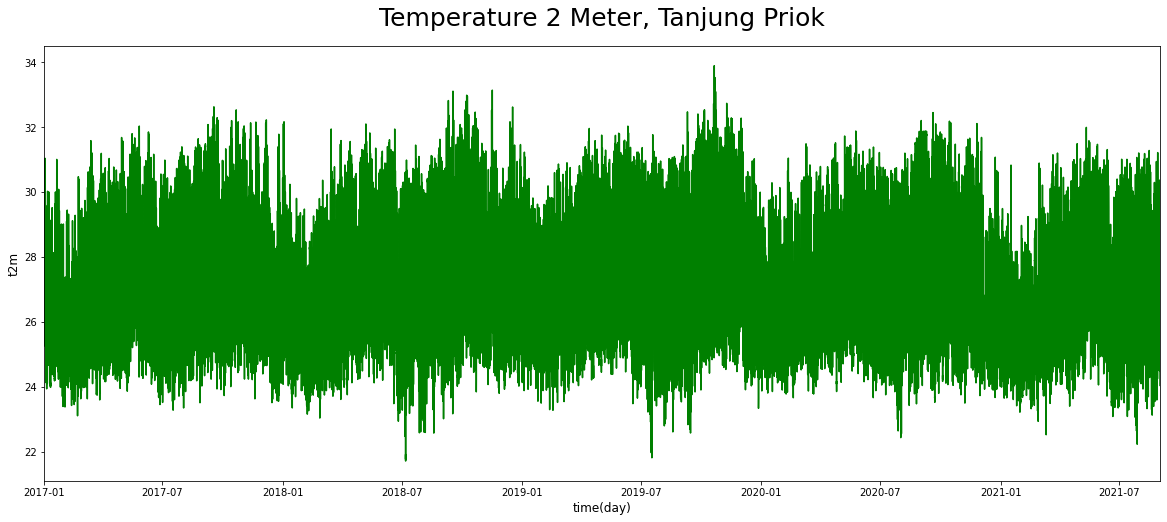

In [ ]:
def timeseries (x_axis, y_axis, x_label):
  plt.figure(figsize = (20, 8))
  plt.plot(x_axis, y_axis, color ='Green')
  plt.xlabel(x_label, {'fontsize': 12}) 
  plt.ylabel('t2m', {'fontsize': 12})
  plt.title('Temperature 2 Meter, Tanjung Priok',pad=20, fontdict={'fontsize':25})
  start = pd.to_datetime(['2017-01-01'])
  end = pd.to_datetime(['2021-09-01'])
  plt.xlim(start,end)


dataset = df.copy()
timeseries(df.index, dataset['t2m'], 'time(day)')

In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (40896, 1).


array([[26.15408769],
       [26.69395032],
       [28.94007682],
       ...,
       [23.64460446],
       [24.58593568],
       [24.42229077]])

Dimension of train data:  (32716, 1)
Dimension of test data:  (8180, 1)


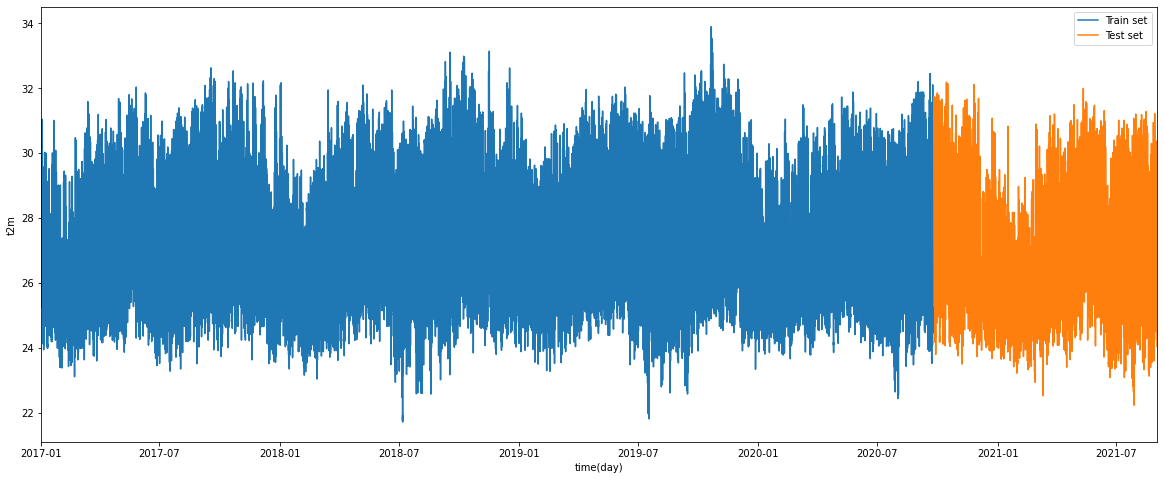

In [ ]:
# split train and test
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]


# Plot train and test data
plt.figure(figsize = (20, 8))
plt.plot(train_data.t2m)
plt.plot(test_data.t2m)
plt.xlabel('time(day)')
plt.ylabel('t2m')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('/content/d/2.jpg', format='jpg', dpi=1000)
start = pd.to_datetime(['2017-01-01'])
end = pd.to_datetime(['2021-09-01'])
plt.xlim(start,end)

print('Dimension of train data: ',train_data.shape)
print('Dimension of test data: ', test_data.shape)

In [ ]:
test_data

,t2m
time,
2020-09-25 11:00:00,30.677040
2020-09-25 12:00:00,31.760156
2020-09-25 13:00:00,31.682316
2020-09-25 14:00:00,31.424297
2020-09-25 15:00:00,30.604594
...,...
2021-09-01 02:00:00,23.897765
2021-09-01 03:00:00,23.620603
2021-09-01 04:00:00,23.644604


In [ ]:
training_set

array([[26.15408769],
       [26.69395032],
       [28.94007682],
       ...,
       [23.64460446],
       [24.58593568],
       [24.42229077]])

In [ ]:
# Scale the data

scaler = MinMaxScaler().fit(train_data)

scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [ ]:
scaled_train
scaled_test

array([[0.73568654],
       [0.82465043],
       [0.81825686],
       ...,
       [0.15806316],
       [0.23538131],
       [0.22194   ]])

In [ ]:
# Create dataset

def create_dataset(X, look_back):
  Xs, Ys = [], []

  for i in range(len(X)-look_back):
    v = X[i:i+look_back]
    Xs.append(v)
    Ys.append(X[i+look_back])

  return np.array(Xs), np.array(Ys)


X_train, Y_train = create_dataset(scaled_train, 24)
X_test, Y_test = create_dataset(scaled_test, 24)

print('X Train Shape: ', X_train.shape)
print('Y Train Shape: ', Y_train.shape)
print('X Test shape: ', X_test.shape)
print('Y Test Shape: ', Y_test.shape)

X Train Shape:  (32692, 24, 1)
Y Train Shape:  (32692, 1)
X Test shape:  (8156, 24, 1)
Y Test Shape:  (8156, 1)


In [ ]:
Y_test

array([[0.69889472],
       [0.78404968],
       [0.77062411],
       ...,
       [0.15806316],
       [0.23538131],
       [0.22194   ]])

# 3. MODEL

### 3.1 ConvBiLSTM

In [ ]:
Conv_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="tanh",
                      input_shape=[X_train.shape[1],X_train.shape[2]]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,activation='tanh', return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
])
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.Adam(lr=3e-4)

Conv_model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mse"])

#Convolutional Bidirectional LSTM . dengan VANILA LSTM atau dengan BiLSTM

In [ ]:
Conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 24, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 165,249
Trainable params: 165,249
Non-trai

### 3.2 BiLSTM

In [ ]:
Bi_model = Sequential()
Bi_model.add(tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences=True, activation='tanh'),input_shape=(X_train.shape[1], X_train.shape[2])))
Bi_model.add(tf.keras.layers.Bidirectional(LSTM(units = 64)))
Bi_model.add(tf.keras.layers.Dropout(0.1))
Bi_model.add(tf.keras.layers.Dense(1))

#optimizer = tf.keras.optimizers.Adam(lr=3e-4)
Bi_model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mse"])


In [ ]:
Bi_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 24, 128)          33792     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)

In [ ]:
history_conv = Conv_model.fit(X_train, Y_train, epochs=50, validation_split=0.2,batch_size = 32, shuffle = False)

Epoch 1/50
818/818 [==============================] - 20s 13ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 2/50
818/818 [==============================] - 10s 12ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 3/50
818/818 [==============================] - 9s 12ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 4/50
818/818 [==============================] - 10s 12ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 8.9687e-04 - val_mse: 0.0018
Epoch 5/50
818/818 [==============================] - 10s 12ms/step - loss: 9.2157e-04 - mse: 0.0018 - val_loss: 0.0010 - val_mse: 0.0021
Epoch 6/50
818/818 [==============================] - 9s 12ms/step - loss: 8.1437e-04 - mse: 0.0016 - val_loss: 8.1225e-04 - val_mse: 0.0016
Epoch 7/50
818/818 [==============================] - 10s 12ms/step - loss: 6.8017e-04 - mse: 0.0014 - val_loss: 6.6058e-04 - val_mse: 0.0013
Epoch 8/50
818/818 [====================

In [ ]:
history_bi = Bi_model.fit(X_train, Y_train, epochs=50, validation_split=0.2,batch_size = 32, shuffle = False, callbacks = [early_stop])

Epoch 1/50
818/818 [==============================] - 15s 12ms/step - loss: 0.0025 - mse: 0.0049 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 2/50
818/818 [==============================] - 9s 11ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 9.7206e-04 - val_mse: 0.0019
Epoch 3/50
818/818 [==============================] - 9s 11ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 4/50
818/818 [==============================] - 9s 11ms/step - loss: 9.8430e-04 - mse: 0.0020 - val_loss: 9.8421e-04 - val_mse: 0.0020
Epoch 5/50
818/818 [==============================] - 9s 11ms/step - loss: 9.4524e-04 - mse: 0.0019 - val_loss: 9.1228e-04 - val_mse: 0.0018
Epoch 6/50
818/818 [==============================] - 9s 12ms/step - loss: 8.7900e-04 - mse: 0.0018 - val_loss: 9.4522e-04 - val_mse: 0.0019
Epoch 7/50
818/818 [==============================] - 9s 11ms/step - loss: 7.8106e-04 - mse: 0.0016 - val_loss: 7.0063e-04 - val_mse: 0.0014
Epoch 8/50
818/818 [============

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.xlim(0,50)
    #plt.savefig('C:/Users/nious/Documents/Medium/Time series/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

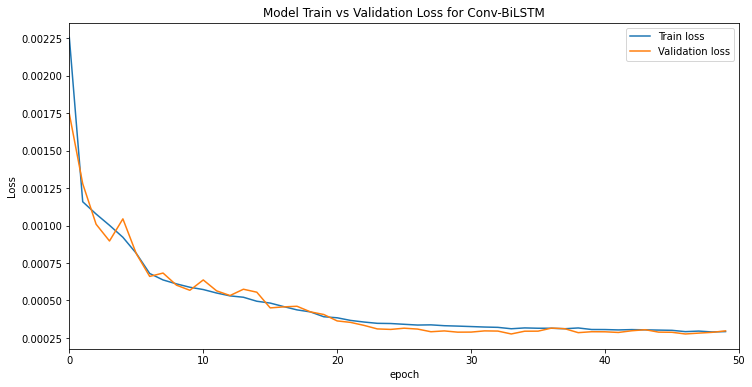

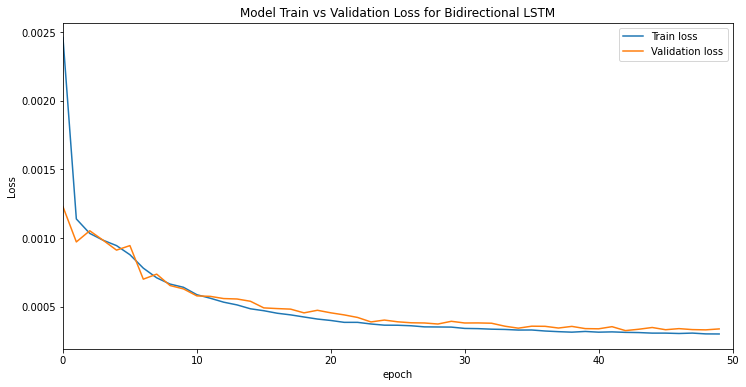

In [ ]:
plot_loss(history_conv, 'Conv-BiLSTM')
plot_loss(history_bi, 'Bidirectional LSTM')

#4. Membuat Prediksi

In [ ]:
#y_test#Transform data back to original data space
Y_test = scaler.inverse_transform(Y_test)
Y_train = scaler.inverse_transform(Y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_convLSTM = prediction(Conv_model)
prediction_Bi = prediction(Bi_model)

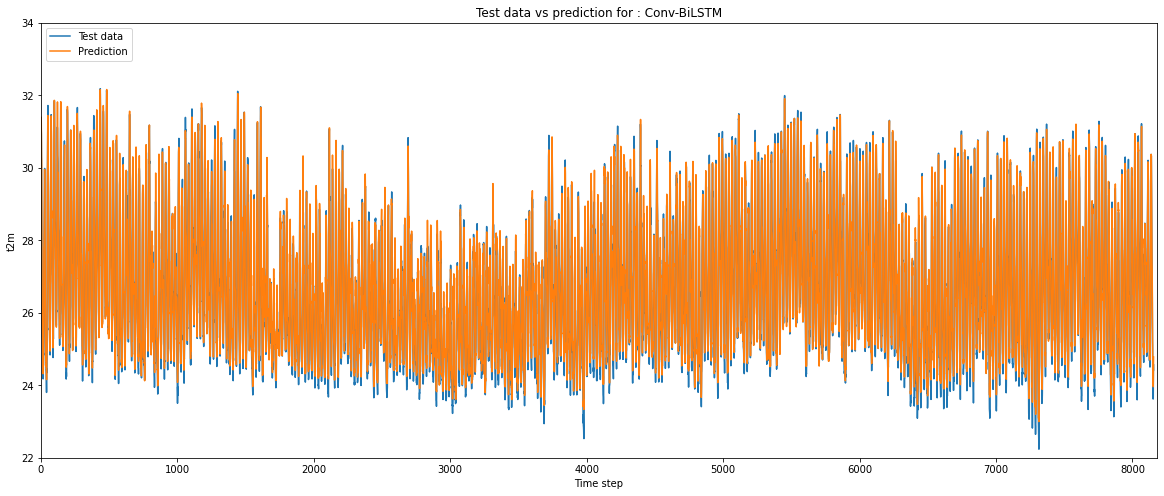

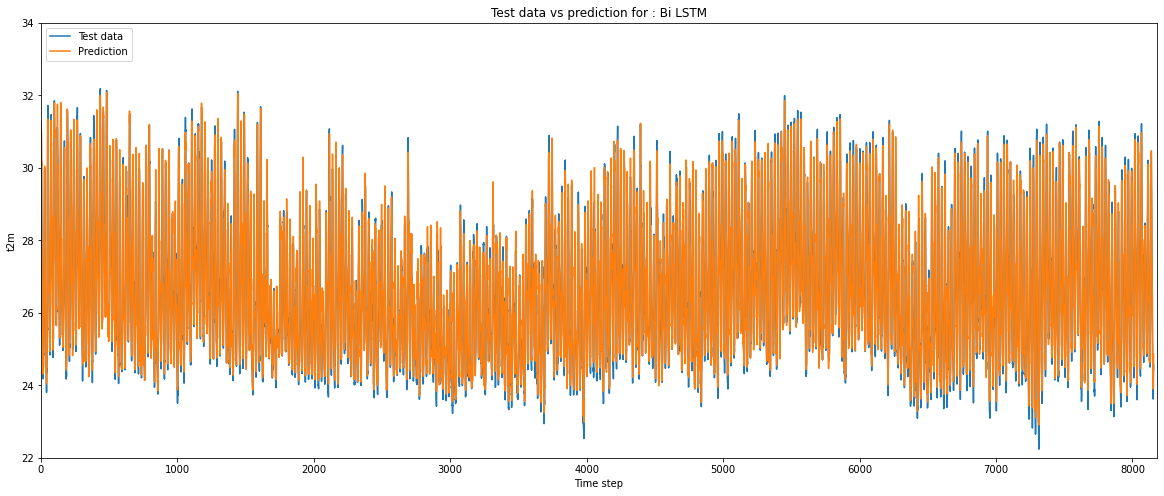

In [ ]:
# Plot test data vs prediction
def plot_future(prediction, y_test, name):
    
    plt.figure(figsize=(20, 8))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for : ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time step')
    plt.ylabel('t2m')
    plt.xlim(0,8180)
    plt.ylim(22,34)

plot_future(prediction_convLSTM, Y_test, 'Conv-BiLSTM')
plot_future(prediction_Bi, Y_test, 'Bi LSTM')

#jangan memakai timestap diganti hari , zoom in zoom out
#forecast 1 hari 2 hari 3 hari, 

In [ ]:
# MAE RMSE CC

def evaluate_prediction(predictions, actual, name):
    scaled_pred = scaler.transform(predictions)
    scaled_actu = scaler.transform(actual)

    errors = (scaled_pred - scaled_actu)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    # Using spearman's correlation
    #corr, _ = spearmanr(scaled_pred, scaled_actu)
    scaled_actu = np.squeeze(actual)
    scaled_pred = np.squeeze(predictions)
    cc = scipy.stats.pearsonr(scaled_actu,scaled_pred)[0]

    print('Model name :' + name)
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Correlation Coefficient: {:.4f}'.format(cc))
    print('')

evaluate_prediction(prediction_convLSTM, Y_test, "Conv LSTM")

evaluate_prediction(prediction_Bi, Y_test, "Bi LSTM")

Model name :Conv LSTM
Mean Absolute Error: 0.0191
Root Mean Square Error: 0.0266
Correlation Coefficient: 0.9890

Model name :Bi LSTM
Mean Absolute Error: 0.0194
Root Mean Square Error: 0.0272
Correlation Coefficient: 0.9876



### 4.1 UJI SKENARIO

In [ ]:
#Scenario Test, 3,7 and 14 day

test_data3 = df['2021-08-01':'2021-08-03'] #3 days = 72 jam
test_data7 = df['2021-08-01':'2021-08-07'] #7 days = 168 jam
test_data14 = df['2021-08-01':'2021-08-14'] #14 days = 336 jam

test_scaled3 = scaler.transform(test_data3)
test_scaled7 = scaler.transform(test_data7)
test_scaled14 = scaler.transform(test_data14)

#lookback
X_test_3, y_test_3 = create_dataset(test_scaled3,24)
X_test_7, y_test_7 = create_dataset(test_scaled7,24)
X_test_14, y_test_14 = create_dataset(test_scaled14,24)


#X_test, y_test = create_dataset(test_scaled,36)
#X_test, y_test = create_dataset(test_scaled,48)

print('X_test_7.shape: ', X_test_7.shape) 
print('y_test_7.shape: ', y_test_7.shape)


X_test_7.shape:  (144, 24, 1)
y_test_7.shape:  (144, 1)


In [ ]:
# Select hour of data from test data
new_data3 = test_data3#.iloc[100:172]
new_data7 = test_data7#.iloc[100:172]
new_data14 = test_data14#.iloc[100:172]

# Scale the input
scaled_data3 = scaler.transform(new_data3)
scaled_data7 = scaler.transform(new_data7)
scaled_data14 = scaler.transform(new_data14)

# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_new3= create_dataset(scaled_data3,24)
X_new7= create_dataset(scaled_data7,24)
X_new14= create_dataset(scaled_data14,24)
print('X_new.shape: ', X_new7.shape) 

X_new.shape:  (144, 24, 1)


In [ ]:
# Make prediction for new data
def prediction(model, X_n):
    prediction = model.predict(X_n)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction1_Conv = prediction(Conv_model,X_new3)
prediction1_Bi = prediction(Bi_model,X_new3)

prediction2_Conv = prediction(Conv_model, X_new7)
prediction2_Bi = prediction(Bi_model, X_new7)

prediction3_Conv = prediction(Conv_model, X_new14)
prediction3_Bi = prediction(Bi_model, X_new14)

# Plot history and future
def plot_multi_step(history, prediction1, prediction2, x_start, x_end):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with Conv-BiLSTM', color = ('red') )
    plt.plot(range_future, np.array(prediction2),label='Forecasted with BiLSTM', color = ('green') )
    
    plt.legend(loc='upper right')
    plt.xlabel('Time step (hour)')
    plt.ylabel('level RAD (m)')
    plt.xlim(x_start,x_end)
   

In [ ]:
def eval(predictions, actual, name):
    pred = scaler.transform(predictions)

    errors = (pred - actual)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    # Using spearman's correlation
    #corr, _ = spearmanr(scaled_pred, scaled_actu)
    actual = np.squeeze(actual)
    pred = np.squeeze(pred)
    cc = scipy.stats.pearsonr(actual,pred)[0]

    print('Model name :' + name)
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Correlation Coefficient: {:.4f}'.format(cc))
    print('')


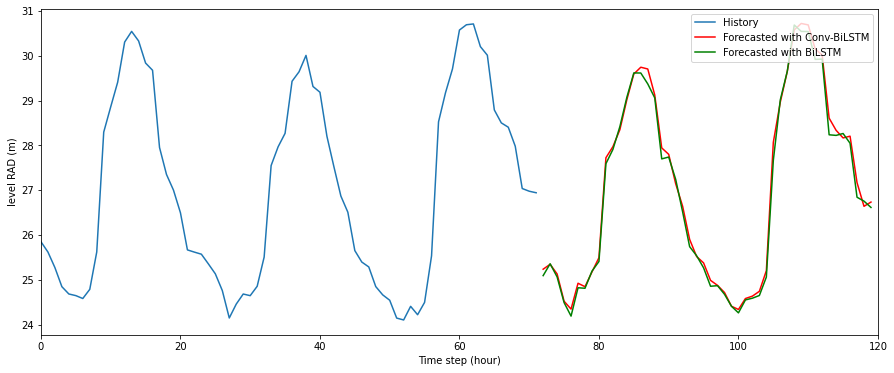

In [ ]:
plot_multi_step(new_data3, prediction1_Conv, prediction1_Bi,0,120)

In [ ]:
eval(prediction1_Conv, y_test_3, 'Conv-Bidirectional LSTM')
eval(prediction1_Bi, y_test_3, 'Bidirectional LSTM')

Model name :Conv-Bidirectional LSTM
Mean Absolute Error: 0.0159
Root Mean Square Error: 0.0187
Correlation Coefficient: 0.9957

Model name :Bidirectional LSTM
Mean Absolute Error: 0.0176
Root Mean Square Error: 0.0220
Correlation Coefficient: 0.9936



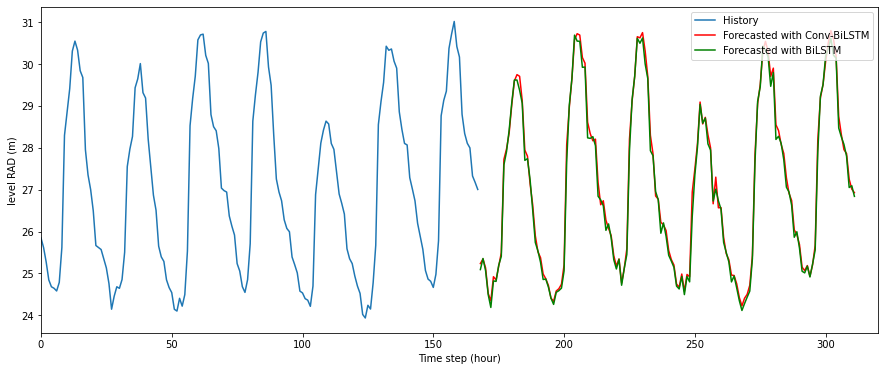

In [ ]:
plot_multi_step(new_data7, prediction2_Conv, prediction2_Bi,0,320)

In [ ]:
eval(prediction2_Conv, y_test_7, 'Conv-Bidirectional LSTM')
eval(prediction2_Bi, y_test_7, 'Bidirectional LSTM')

Model name :Conv-Bidirectional LSTM
Mean Absolute Error: 0.0156
Root Mean Square Error: 0.0205
Correlation Coefficient: 0.9941

Model name :Bidirectional LSTM
Mean Absolute Error: 0.0175
Root Mean Square Error: 0.0234
Correlation Coefficient: 0.9920



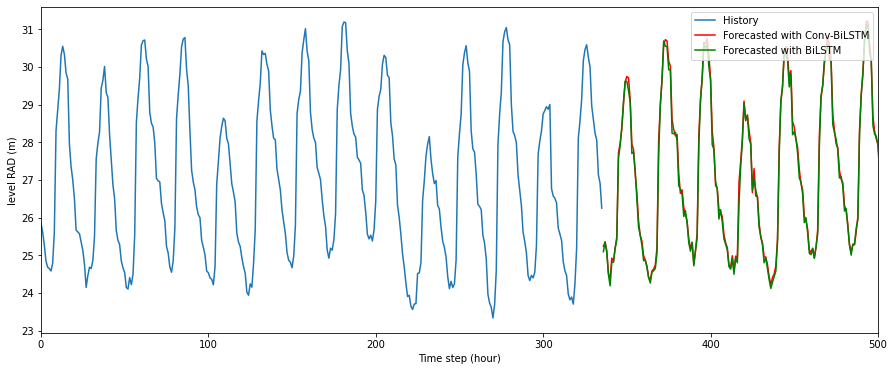

In [ ]:
plot_multi_step(new_data14, prediction3_Conv, prediction3_Bi,0,500)

In [ ]:
eval(prediction3_Conv, y_test_14, 'Conv-Bidirectional LSTM')
eval(prediction3_Bi, y_test_14, 'Bidirectional LSTM')

Model name :Conv-Bidirectional LSTM
Mean Absolute Error: 0.0175
Root Mean Square Error: 0.0251
Correlation Coefficient: 0.9915

Model name :Bidirectional LSTM
Mean Absolute Error: 0.0193
Root Mean Square Error: 0.0275
Correlation Coefficient: 0.9892



#99. HyperParameter Tuning

In [ ]:
#dfd = d.set_index('time').resample("D").mean()
df_HP = df['2020-09-01':'2020-11-01'] ## 3 month

In [ ]:
df_HP

,t2m
time,
2020-09-01 00:00:00,25.973894
2020-09-01 01:00:00,25.696199
2020-09-01 02:00:00,25.562935
2020-09-01 03:00:00,24.935345
2020-09-01 04:00:00,24.683004
...,...
2020-11-01 19:00:00,26.668242
2020-11-01 20:00:00,26.517049
2020-11-01 21:00:00,26.078261


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	#n_input, n_nodes, n_epochs, n_batch, n_diff = config
  n_input, n_nodes, n_epochs, n_batch, n_dropout, n_diff = config
	# prepare data
  if n_diff > 0:
    train = difference(train, n_diff)
  # transform series into supervised format
  data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
  train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
  n_features = 1
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
  model = Sequential()
  model.add(Bidirectional(LSTM(n_nodes, return_sequences = True, activation='tanh', input_shape=(n_input, n_features))))
  model.add(Bidirectional(LSTM(n_nodes)))
  model.add(Dropout(n_dropout))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
	# fit model
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [ ]:
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error


In [ ]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)


In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [24]
	n_nodes = [32,64]
	n_epochs = [25,50]
	n_batch = [16,32,64]
	n_dropout = [0.1, 0.3, 0.5]
	#n_lr = [0.01, 0.00001, 0.0003]
	n_diff = [1]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_dropout:
						for n in n_diff:
							cfg = [i, j, k, l, m, n]
							configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [ ]:
'''
    n_input: The number of prior inputs to use as input for the model (e.g. 12 months).
    n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
    n_epochs: The number of training epochs (e.g. 1000).
    n_batch: The number of samples to include in each mini-batch (e.g. 32).
    n_diff: The difference order (e.g. 0 or 12).
'''

'\n    n_input: The number of prior inputs to use as input for the model (e.g. 12 months).\n    n_nodes: The number of nodes to use in the hidden layer (e.g. 50).\n    n_epochs: The number of training epochs (e.g. 1000).\n    n_batch: The number of samples to include in each mini-batch (e.g. 32).\n    n_diff: The difference order (e.g. 0 or 12).\n'

In [ ]:
data = df_HP.values
n_test = 298 # 20% of data
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 36
 > 0.386
 > 0.378
 > 0.379
 > 0.384
 > 0.379
 > 0.377
 > 0.382
 > 0.380
 > 0.382
 > 0.379
> Model[[24, 32, 25, 16, 0.1, 1]] 0.381
 > 0.382
 > 0.387
 > 0.386
 > 0.405
 > 0.385
 > 0.380
 > 0.384
 > 0.383
 > 0.390
 > 0.388
> Model[[24, 32, 25, 16, 0.3, 1]] 0.387
 > 0.413
 > 0.388
 > 0.390
 > 0.382
 > 0.391
 > 0.391
 > 0.395
 > 0.391
 > 0.386
 > 0.395
> Model[[24, 32, 25, 16, 0.5, 1]] 0.392
 > 0.392
 > 0.391
 > 0.390
 > 0.381
 > 0.387
 > 0.395
 > 0.381
 > 0.389
 > 0.389
 > 0.382
> Model[[24, 32, 25, 32, 0.1, 1]] 0.388
 > 0.394
 > 0.393
 > 0.396
 > 0.396
 > 0.395
 > 0.391
 > 0.390
 > 0.401
 > 0.388
 > 0.393
> Model[[24, 32, 25, 32, 0.3, 1]] 0.394
 > 0.396
 > 0.394
 > 0.396
 > 0.397
 > 0.394
 > 0.399
 > 0.397
 > 0.406
 > 0.396
 > 0.393
> Model[[24, 32, 25, 32, 0.5, 1]] 0.397
 > 0.408
 > 0.405
 > 0.423
 > 0.397
 > 0.403
 > 0.402
 > 0.399
 > 0.400
 > 0.396
 > 0.401
> Model[[24, 32, 25, 64, 0.1, 1]] 0.403
 > 0.404
 > 0.397
 > 0.407
 > 0.400
 > 0.399
 > 0.398
 > 0.401
 > 0.400


In [ ]:
'''
Total configs: 36
> Model[[24, 32, 25, 16, 0.1, 1]] 0.381
> Model[[24, 32, 25, 16, 0.3, 1]] 0.387
> Model[[24, 32, 25, 16, 0.5, 1]] 0.392
> Model[[24, 32, 25, 32, 0.1, 1]] 0.388
> Model[[24, 32, 25, 32, 0.3, 1]] 0.394
> Model[[24, 32, 25, 32, 0.5, 1]] 0.397
> Model[[24, 32, 25, 64, 0.1, 1]] 0.403
> Model[[24, 32, 25, 64, 0.3, 1]] 0.402
> Model[[24, 32, 25, 64, 0.5, 1]] 0.406
> Model[[24, 32, 50, 16, 0.1, 1]] 0.370
> Model[[24, 32, 50, 16, 0.3, 1]] 0.373
> Model[[24, 32, 50, 16, 0.5, 1]] 0.377
> Model[[24, 32, 50, 32, 0.1, 1]] 0.371
> Model[[24, 32, 50, 32, 0.3, 1]] 0.375
> Model[[24, 32, 50, 32, 0.5, 1]] 0.380
> Model[[24, 32, 50, 64, 0.1, 1]] 0.384
> Model[[24, 32, 50, 64, 0.3, 1]] 0.386
> Model[[24, 32, 50, 64, 0.5, 1]] 0.392
> Model[[24, 64, 25, 16, 0.1, 1]] 0.377
> Model[[24, 64, 25, 16, 0.3, 1]] 0.383
> Model[[24, 64, 25, 16, 0.5, 1]] 0.385
> Model[[24, 64, 25, 32, 0.1, 1]] 0.382
> Model[[24, 64, 25, 32, 0.3, 1]] 0.384
> Model[[24, 64, 25, 32, 0.5, 1]] 0.389
> Model[[24, 64, 25, 64, 0.1, 1]] 0.387
> Model[[24, 64, 25, 64, 0.3, 1]] 0.392
> Model[[24, 64, 25, 64, 0.5, 1]] 0.398
> Model[[24, 64, 50, 16, 0.1, 1]] 0.367
> Model[[24, 64, 50, 16, 0.3, 1]] 0.371
> Model[[24, 64, 50, 16, 0.5, 1]] 0.376
> Model[[24, 64, 50, 32, 0.1, 1]] 0.366
> Model[[24, 64, 50, 32, 0.3, 1]] 0.373
> Model[[24, 64, 50, 32, 0.5, 1]] 0.379
> Model[[24, 64, 50, 64, 0.1, 1]] 0.376
> Model[[24, 64, 50, 64, 0.3, 1]] 0.380
> Model[[24, 64, 50, 64, 0.5, 1]] 0.380
done
[24, 64, 50, 32, 0.1, 1] 0.3663019291751294 ->> THE BEST BABY
[24, 64, 50, 16, 0.1, 1] 0.3674447340217434
[24, 32, 50, 16, 0.1, 1] 0.37009097416883563
'''

'\nTotal configs: 36\n> Model[[24, 32, 25, 16, 0.1, 1]] 0.381\n> Model[[24, 32, 25, 16, 0.3, 1]] 0.387\n> Model[[24, 32, 25, 16, 0.5, 1]] 0.392\n> Model[[24, 32, 25, 32, 0.1, 1]] 0.388\n> Model[[24, 32, 25, 32, 0.3, 1]] 0.394\n> Model[[24, 32, 25, 32, 0.5, 1]] 0.397\n> Model[[24, 32, 25, 64, 0.1, 1]] 0.403\n> Model[[24, 32, 25, 64, 0.3, 1]] 0.402\n> Model[[24, 32, 25, 64, 0.5, 1]] 0.406\n> Model[[24, 32, 50, 16, 0.1, 1]] 0.370\n> Model[[24, 32, 50, 16, 0.3, 1]] 0.373\n> Model[[24, 32, 50, 16, 0.5, 1]] 0.377\n> Model[[24, 32, 50, 32, 0.1, 1]] 0.371\n> Model[[24, 32, 50, 32, 0.3, 1]] 0.375\n> Model[[24, 32, 50, 32, 0.5, 1]] 0.380\n> Model[[24, 32, 50, 64, 0.1, 1]] 0.384\n> Model[[24, 32, 50, 64, 0.3, 1]] 0.386\n> Model[[24, 32, 50, 64, 0.5, 1]] 0.392\n> Model[[24, 64, 25, 16, 0.1, 1]] 0.377\n> Model[[24, 64, 25, 16, 0.3, 1]] 0.383\n> Model[[24, 64, 25, 16, 0.5, 1]] 0.385\n> Model[[24, 64, 25, 32, 0.1, 1]] 0.382\n> Model[[24, 64, 25, 32, 0.3, 1]] 0.384\n> Model[[24, 64, 25, 32, 0.5, 1]] 0